# Game Of Life map generation

In [198]:
from matplotlib import pyplot as plt
import numpy as np
import math

In [199]:
ON = 1  #0.6 probability
OFF = 0 #0.4 probability

vals = [ON, OFF]
rng = np.random.default_rng(12345)
 
def randomGrid(N):
    return rng.choice(vals, N*N, p=[0.6, 0.4]).reshape(N, N)

def update(grid, N):
    # N is map size, assuming that dimensions are N x N

    # copy grid since we require 8 neighbors
    # for calculation and we go line by line
    newGrid = grid.copy()
    for i in range(N):
        for j in range(N):
 
            # compute 8-neighbor sum
            # using toroidal boundary conditions - x and y wrap around
            # so that the simulation takes place on a toroidal surface.
            total = int((grid[i, (j-1)%N] + grid[i, (j+1)%N] +
                         grid[(i-1)%N, j] + grid[(i+1)%N, j] +
                         grid[(i-1)%N, (j-1)%N] + grid[(i-1)%N, (j+1)%N] +
                         grid[(i+1)%N, (j-1)%N] + grid[(i+1)%N, (j+1)%N]))
 
            # apply Conway's rules
            if grid[i, j]  == ON:
                if (total < 2) or (total > 3):
                    newGrid[i, j] = OFF
            else:
                if total == 3:
                    newGrid[i, j] = ON
                    
    return newGrid

def runGOL():     
    # set grid size
    N = 100
         
    # set animation update interval
    totalTimeSteps = 200
 
    # declare grid
    grid = np.array([])

    grid = randomGrid(N)

    for i in range(totalTimeSteps):
        grid[:] = update(grid, N)[:]
 
    return grid


In [200]:
CLR_MAP = {
    0: (0, 0, 0),  # black, wall
    1: (255, 255, 255),  # white, space/path
}

# initialize map
map_height = 100
map_width = map_height

# * height is y, width is x
# * so map_np[y,x]
# * origin point is at top left

# Generate map
init_map_np = runGOL()

# border walls
# top
init_map_np[0, :] = 1
# bottom
init_map_np[map_height - 1, :] = 1
# left
init_map_np[:, 0] = 1
# right
init_map_np[:, map_width - 1] = 1

# Remove walls in snake's starting position
start_position_area_y = range(2,16)
start_position_area_x = range(2,9)


for y in start_position_area_y:
    for x in start_position_area_x:
        init_map_np[y,x] = 0

map_np = init_map_np.copy()

print(map_np)

[[1 1 1 ... 1 1 1]
 [1 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 1]
 ...
 [1 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 1]
 [1 1 1 ... 1 1 1]]


## Define utility functions/ classes

In [201]:
#For storage later
class Coordinates:
    def __init__(self, y, x):
        self.y = y
        self.x = x

def isBoundary(coordinate, excludeBottom=False):
    x = coordinate.x
    y = coordinate.y
    if excludeBottom:
        if y == map_height-1:
            if x != map_width-1 or x != 1:
                return False
    else: 
        if x == 0 or y == 0 or x == map_width-1 or y == map_height-1:
            return True
    return False

def findWallCoordinates(map_np, includeBottomBoundary=False):
    wallCoordinates = []

    for y in range(1,map_np.shape[0]-1):
        for x in range(1,map_np.shape[1]-1):
            if map_np[y,x] == ON:
                wallCoordinates.append(Coordinates(y,x))

    if includeBottomBoundary:
        for x in range(1,map_np.shape[1]-2):
            wallCoordinates.append(Coordinates(map_np.shape[0]-1, x))

    return wallCoordinates

def getCardinalCoordinates(map_np, coordinate, includeBoundaries=False):
    #Attempt to get the cardinal coordinates so long as they aren't boundaries/walls
    cardinalCoordinates = {}
    x = coordinate.x
    y = coordinate.y
    #Get left:
    if not includeBoundaries:
        if x != 0 and x != 1 and map_np[y,x-1] != 1:
                cardinalCoordinates["left"] = Coordinates(y,x-1) 
        #Get right:
        if  x != map_np.shape[1]-1 and  x != map_np.shape[1]-2 and map_np[y,x+1] != 1:
            cardinalCoordinates["right"] = Coordinates(y,x+1)
        #Get top:
        if y != 0 and y != 1 and map_np[y-1,x] != 1:
            cardinalCoordinates["top"] = Coordinates(y-1,x)
        #Get bottom:
        try:
            if y != map_np.shape[0]-1 and y != map_np.shape[0]-2 and map_np[y+1,x] != 1:
                cardinalCoordinates["bottom"] = Coordinates(y+1,x)
        except:
            print("issue is here!!")
    else: 
        if x != 0 and map_np[y,x-1] != 1:
            cardinalCoordinates["left"] = Coordinates(y,x-1) 
        #Get right:
        if x != map_np.shape[1]-1 and map_np[y,x+1] != 1:
            cardinalCoordinates["right"] = Coordinates(y,x+1)
        #Get top:
        if y != 0 and map_np[y-1,x] != 1:
            cardinalCoordinates["top"] = Coordinates(y-1,x)
        #Get bottom:
        if y != map_np.shape[0]-1 and map_np[y+1,x] != 1:
                cardinalCoordinates["bottom"] = Coordinates(y+1,x)
    return cardinalCoordinates

def getNonCardinalCoordinates(map_np, coordinate, includeBoundaries=False):
    #Attempt to get the NonCardinal coordinates so long as they aren't boundaries 
    #AND IF THEY **ARE** (not aren't) WALLS <--- VERY IMPORTANT
    nonCardinalCoordinates = {}
    x = coordinate.x
    y = coordinate.y
    if not includeBoundaries:
        #Get top-left:
        if x != 0 and y != 0 and x != 1 and y != 1 and map_np[y-1,x-1] == 1:
            nonCardinalCoordinates["topLeft"] = Coordinates(y-1,x-1)
        #Get top-right:
        if x != map_np.shape[1]-1 and y != 0 and x != map_np.shape[1]-2 and y != 1 and map_np[y-1,x+1] == 1:
            nonCardinalCoordinates["topRight"] = Coordinates(y-1,x+1)
        #Get bottom-left:
        if y != map_np.shape[0]-1 and x != 0 and y != map_np.shape[0]-2 and x != 1 and map_np[y+1,x-1] == 1:
            nonCardinalCoordinates["bottomLeft"] = Coordinates(y+1,x-1)
        #Get bottom-right:
        if y != map_np.shape[0]-1 and x != map_np.shape[1]-1 and y != map_np.shape[0]-2 and x != map_np.shape[1]-2 and map_np[y+1,x+1] == 1:
            nonCardinalCoordinates["bottomRight"] = Coordinates(y+1,x+1)
    else: 
        #Get top-left:
        if x != 0 and y != 0 and map_np[y-1,x-1] == 1:
            nonCardinalCoordinates["topLeft"] = Coordinates(y-1,x-1)
        #Get top-right:
        if x != map_np.shape[1]-1 and y != 0 and map_np[y-1,x+1] == 1:
            nonCardinalCoordinates["topRight"] = Coordinates(y-1,x+1)
        #Get bottom-left:
        if y != map_np.shape[0]-1 and x != 0 and map_np[y+1,x-1] == 1:
            nonCardinalCoordinates["bottomLeft"] = Coordinates(y+1,x-1)
        #Get bottom-right:
        if y != map_np.shape[0]-1 and x != map_np.shape[1]-1 and map_np[y+1,x+1] == 1:
            nonCardinalCoordinates["bottomRight"] = Coordinates(y+1,x+1)
    return nonCardinalCoordinates

In [202]:
def recurseFill(map_np, coordinate):
    cardinalDict = getCardinalCoordinates(map_np, coordinate)
    nonCardindalDict = getNonCardinalCoordinates(map_np, coordinate)

    #Gonna ignore top for now, 
    #since we process the map from top to bottom, 
    #we probably cover top cases ard

    #If right, we'll check top right and btm right
    if "right" in cardinalDict:
        if "topRight" in nonCardindalDict or "bottomRight" in nonCardindalDict:
            #Fill/Convert into wall
            map_np[cardinalDict["right"].y, cardinalDict["right"].x] = 1
            recurseFill(map_np, cardinalDict["right"])

    #If bottom, we'll check bottom left and bottom right
    if "bottom" in cardinalDict:
        if "bottomLeft" in nonCardindalDict or "bottomRight" in nonCardindalDict:
            #Fill/Convert into wall
            map_np[cardinalDict["bottom"].y, cardinalDict["bottom"].x] = 1
            recurseFill(map_np, cardinalDict["bottom"])

    #If left, we'll check top left and bottom left
    if "left" in cardinalDict:
        if "bottomLeft" in nonCardindalDict or "topLeft" in nonCardindalDict:
            #Fill/Convert into wall
            map_np[cardinalDict["left"].y, cardinalDict["left"].x] = 1
            recurseFill(map_np, cardinalDict["left"])

Example of a "dead end", should a fruit spawn in the holes within the walls, the game is guaranteed to lose after reaching the fruit
<p>

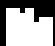 


In [203]:
def deadEndFill(map_np, coordinate):
    #The role of this function is to fill up the "dead ends"

    if isBoundary(coordinate, excludeBottom=True):
        return
        
    cardinalDict = getCardinalCoordinates(map_np, coordinate)
    nonCardindalDict = getNonCardinalCoordinates(map_np, coordinate)
    
    #Unlike recurse fill, we only need to check the top cells 
    if "top" in cardinalDict:
        if "topRight" in nonCardindalDict and "topLeft" in nonCardindalDict:
            map_np[cardinalDict["top"].y, cardinalDict["top"].x] = 1
            deadEndFill(map_np, cardinalDict["top"])

# Fill up the map

In [204]:
wallCoordinates = findWallCoordinates(map_np)

for coordinate in wallCoordinates:
    recurseFill(map_np, coordinate)

wallCoordinates = findWallCoordinates(map_np, includeBottomBoundary=True)

for coordinate in wallCoordinates:
    deadEndFill(map_np, coordinate)

## Define and calculate fitness function

The idea behind this is to have relatively well distributed obstacles across all 4 sectors of the map. Ideally, we would have a 35:65 obstacle to path ratio throughout the map, as such, cross entropy is used to compare the distribution of obstacles from the algorithm to the ideal distribution. Additionally, we purposely split the map into 4 sectors and calculate its average for this evaluation function is such that the distribution isn't too lopsided for any particular sector. I.e. the algorithm could hypothetically generate 35% of its cells as wall cells ONLY on the bottom right of the map, if we only calculate a general cross-entropy score for the entire map, we would not be able to determine whether there's anything wrong.

Steps for the fitness function:
1. Split the map into 4 equal sectors
2. Calculate the cross entropy for each sector against a targeted distribution of 35% walls, 65% open space
3. Obtain an average of the cross entropy values, the higher the average cross entropy, the worse the map generated

Cross entropy formula:
</br> 

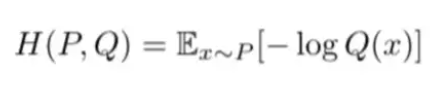

In [205]:
def splitMap(map_np):
    #To split the map into 4 sectors, 
    #all we need to do is to split each axis by half
    height = map_np.shape[0]
    width = map_np.shape[1]
    
    height_midpoint = height//2
    width_midpoint = width//2
    return height_midpoint, width_midpoint

def crossEntropyEval(sector_np):
    # Takes in a slice of the usual map_np

    # First we calculate the total area of the sector:
    area = sector_np.shape[0] * sector_np.shape[1]
    wallCount = 0
    pathCount = 0
    
    # Next we obtain the number of wall cells and 
    # derive path cell count from it
    # Boundaries should not be included as part of sector_np
    for y in range(0,sector_np.shape[0]-1):
        for x in range(0,sector_np.shape[1]-1):
            if sector_np[y,x] == ON:
                wallCount += 1
    pathCount = area - wallCount

    crossEntropy = -(35/100*math.log(wallCount/area) + 65/100*math.log(pathCount/area))
    return crossEntropy


In [206]:
height_midpoint, width_midpoint =splitMap(map_np)

sector1 = map_np[1:height_midpoint, 1:width_midpoint]
sector2 = map_np[1:height_midpoint, width_midpoint:map_width-1]
sector3 = map_np[height_midpoint:map_height-1, 1:width_midpoint]
sector4 = map_np[height_midpoint:map_height-1, width_midpoint:map_width-1]

sectors = [sector1, sector2, sector3, sector4]

crossEntropySum = 0
for sector in sectors:
    crossEntropySum += crossEntropyEval(sector)

avgCrossEntropy = crossEntropySum/4
print(f"Evaluation score is: {avgCrossEntropy}")


Evaluation score is: 0.771300064378523


# Plot the map

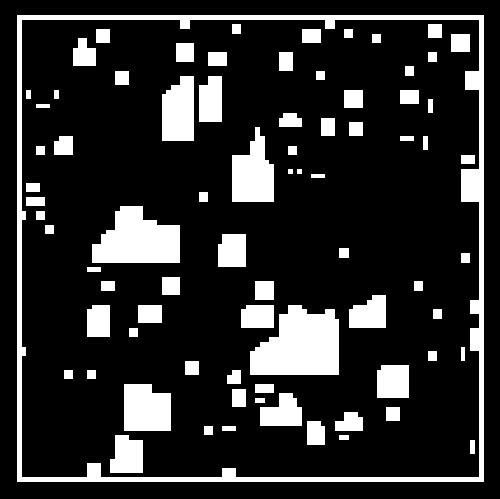

In [207]:
# convert to RGB Map
color_map_np = np.zeros((map_np.shape[0], map_np.shape[1], 3), dtype=np.uint8)

for y in range(map_np.shape[0]):
    for x in range(map_np.shape[1]):
        color = CLR_MAP[map_np[y, x]]
        color_map_np[y, x] = np.array(color)

plt.figure(facecolor='black')
plt.tight_layout()
plt.axis("off")   # turns off axes
plt.axis("tight")  # gets rid of white border
plt.axis("image")  # square up the image instead of filling the "figure" space
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.xlim([-2, map_width + 1])
plt.ylim([map_height + 1, -2])
plt.imshow(color_map_np, interpolation='nearest')
# plt.gcf().set_dpi(300)
# plt.savefig("test.png",bbox_inches='tight')
plt.show()

In [208]:
# output map
# Writing to file
with open("./map/dummy_map.txt", "w") as file:
    # Writing data to a file
    for y in range(map_np.shape[0]):
        # print(''.join(map(str,map_np[y, :].tolist())))
        file.write(''.join(map(str,map_np[y, :].tolist()))+'\n')


In [209]:
with open("./map/dummy_map.txt") as f:
    lines = f.readlines()
# check height & width
map_height = len(lines)
map_width = len(lines[0].strip())
map_repr = [ [0]*map_width for _ in range(map_height) ]
print(f"map_height: {map_height}")
print(f"map_width: {map_width }")

for y in range(len(lines)):
    line = lines[y].strip()
    for x in range(len(line)):
        map_repr[y][x] = int(line[x])

print(map_repr)


map_height: 100
map_width: 100
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0